In [116]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [117]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

In [118]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,K_max,S_max,N_test,f_type,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    num_basis_funcs = K_max+1
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k,Noise)
    #initialize function
    f_vals_vanilla = X_test
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_2 = np.zeros_like(bar_a_1)
    alpha = 1./4*gamma*(sig**2)*(1./(1-gamma*a) + 1.)
    beta = gamma*(a*c-1./2*sig**2)
    for i in range(lag):
        #second-order coefficients
        #bar_a_2[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(X_test[:-1]))**2
        #bar_a_2[i,0] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(x0))**2
        bar_a_2[i,1:] = coefs_poly_regr[i,1]*np.sqrt(2)*alpha +\
                    coefs_poly_regr[i,2]*np.sqrt(2)*(7*alpha**2 + gamma*(sigma(X_test[:-1]))**2)
        bar_a_2[i,0] = coefs_poly_regr[i,1]*np.sqrt(2)*alpha +\
                    coefs_poly_regr[i,2]*np.sqrt(2)*(7*alpha**2 + gamma*(sigma(x0))**2)
        #first-order coefficients
        #bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                #coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(X_test[:-1])*(X_test[:-1]+gamma*b(X_test[:-1]))
        bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                coefs_poly_regr[i,2]*(2*((1-gamma*a)*X_test[:-1] + beta)*(np.sqrt(gamma)*sigma(X_test[:-1]) + alpha) +\
                                    6*alpha*sigma(X_test[:-1])*np.sqrt(gamma))
        bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                coefs_poly_regr[i,2]*(2*((1-gamma*a)*x0 + beta)*(np.sqrt(gamma)*sigma(x0) + alpha) +\
                                    6*alpha*sigma(x0)*np.sqrt(gamma))        
        #bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                        #coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(x0)*(x0+gamma*b(x0))
    bar_a_1 = bar_a_1*poly_vals[1,:]
    bar_a_2 = bar_a_2*poly_vals[2,:]
    #compute martingale sums
    M_n_1 = 0.0
    M_n_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1 += bar_a_1[r,l]
            M_n_2 += bar_a_2[r,l]
    print("M_n_2: ",M_n_2)
    print("M_n_1: ",M_n_1)
    return np.mean(f_vals_vanilla),np.mean(f_vals_vanilla)-M_n_1/N_test,np.mean(f_vals_vanilla)-M_n_1/N_test-M_n_2/N_test

In [119]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        print("variance: ",np.var(y_all))
        print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [120]:
a = 5.0
c = 5.0
sig = 2.0

def b(X_t):
    """
    b function in the diffusion
    """
    return a*(c-X_t)

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.sqrt(X_t)

def sample_discretized_diffusion(X_t,gamma_t):
    """
    args:   X_t - current value, 
            gamma_t - step size;
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn()
    return (1-gamma_t*a)*X_t + gamma_t*(a*c-1./4*(sig**2)) + np.sqrt(gamma_t*X_t)*sig*xi + 0.25*gamma_t*(sig**2)*(xi**2 + (xi**2)/(1-gamma_t*a) - 1),xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros(n,dtype = float)
    noise_all = np.zeros(n,dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [121]:
n = 2*10**4 #sample size
gamma = 1e-2 # Step size
n_traj = 100
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 100 #maximal lag order
N_test = 2*10**3

Sample discretized diffusion

In [122]:
def generate_observations(x0,n,gamma,r_seed,n_traj):
    X_train_all = np.zeros((n_traj,n,1),dtype=float)
    Noise_train_all = np.zeros_like(X_train_all)
    Y_train_all = np.zeros((n_traj,n,1),dtype=float)
    for i in range(n_traj):
        X_train, noise_train = generate_traj(x0,n,gamma,r_seed+i)
        #set target function
        Y_train = X_train
        X_train_all[i,:,0] = X_train
        Y_train_all[i,:,0] = Y_train
        Noise_train_all[i,:,0] = noise_train
        #X_train = X_train.reshape((1,-1,d))
        #Y_train = Y_train.reshape((1,-1,1))
    return X_train_all, Noise_train_all, Y_train_all

In [123]:
x0 = 1
r_seed = 1812
X_train, noise_train, Y_train = generate_observations(x0,n,gamma,r_seed,n_traj)
X_train_1, noise_train_1, Y_train_1 = generate_observations(x0,n,2*gamma,r_seed,n_traj)
X_train_2, noise_train_2, Y_train_2 = generate_observations(x0,n,3*gamma,r_seed,n_traj)
X_train_3, noise_train_3, Y_train_3 = generate_observations(x0,n,4*gamma,r_seed,n_traj)
X_train_4, noise_train_4, Y_train_4 = generate_observations(x0,n,5*gamma,r_seed,n_traj)
#set target function
#X_train = X_train.reshape((1,-1,1))
#Y_train = Y_train.reshape((1,-1,1))

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [124]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
coefs_poly_1 = approx_q(X_train_1,Y_train_1,n_traj,lag,S_max)
coefs_poly_2 = approx_q(X_train_2,Y_train_2,n_traj,lag,S_max)
coefs_poly_3 = approx_q(X_train_3,Y_train_3,n_traj,lag,S_max)
coefs_poly_4 = approx_q(X_train_4,Y_train_4,n_traj,lag,S_max)
print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
for i in range(len(regr_vals)):
    for j in range(S_max+1):
        regr_vals[i,:] += coefs_poly[i,j]*X_train[0,:,0]**j

dimension =  20000
variance:  2.0899943697900487
[1.11285866 1.2255869  1.55271243 1.81105758 1.75029627 1.65280518
 2.21387003 2.74105429 2.58837509 3.0605777  3.66908742 3.43003029
 3.26323434 3.48087211 3.68928895 3.07141543 2.75347673 2.78328609
 2.99254283 3.23248039 3.48558467 3.48161464 3.52823879 3.74045447
 3.79148263 4.42797009 4.4768625  4.86199417 4.83148923 5.14511952
 4.80503389 4.43393323 4.54337947 4.64258046 4.56072147 5.34903561
 5.94173732 5.60456608 4.95761333 4.05923911 3.53537388 4.22319737
 4.40223358 4.57778945 4.54046422 4.05443041 3.76322632 3.58416409
 3.09853922 3.60274567]
(2000000, 3)
variance:  2.0893644516329144
[1.2255869  1.55271243 1.81105758 1.75029627 1.65280518 2.21387003
 2.74105429 2.58837509 3.0605777  3.66908742 3.43003029 3.26323434
 3.48087211 3.68928895 3.07141543 2.75347673 2.78328609 2.99254283
 3.23248039 3.48558467 3.48161464 3.52823879 3.74045447 3.79148263
 4.42797009 4.4768625  4.86199417 4.83148923 5.14511952 4.80503389
 4.43393323 4

variance:  2.085588841373846
[3.68928895 3.07141543 2.75347673 2.78328609 2.99254283 3.23248039
 3.48558467 3.48161464 3.52823879 3.74045447 3.79148263 4.42797009
 4.4768625  4.86199417 4.83148923 5.14511952 4.80503389 4.43393323
 4.54337947 4.64258046 4.56072147 5.34903561 5.94173732 5.60456608
 4.95761333 4.05923911 3.53537388 4.22319737 4.40223358 4.57778945
 4.54046422 4.05443041 3.76322632 3.58416409 3.09853922 3.60274567
 3.16179801 3.24660245 3.16090388 3.60372309 3.79587744 4.13814625
 4.40957779 4.53668206 4.14375436 3.89963825 4.22899249 4.6076403
 4.22215846 5.2695754 ]
(1998600, 3)
variance:  2.0854790033487
[3.07141543 2.75347673 2.78328609 2.99254283 3.23248039 3.48558467
 3.48161464 3.52823879 3.74045447 3.79148263 4.42797009 4.4768625
 4.86199417 4.83148923 5.14511952 4.80503389 4.43393323 4.54337947
 4.64258046 4.56072147 5.34903561 5.94173732 5.60456608 4.95761333
 4.05923911 3.53537388 4.22319737 4.40223358 4.57778945 4.54046422
 4.05443041 3.76322632 3.58416409 3.09

variance:  2.0848522497758704
[4.83148923 5.14511952 4.80503389 4.43393323 4.54337947 4.64258046
 4.56072147 5.34903561 5.94173732 5.60456608 4.95761333 4.05923911
 3.53537388 4.22319737 4.40223358 4.57778945 4.54046422 4.05443041
 3.76322632 3.58416409 3.09853922 3.60274567 3.16179801 3.24660245
 3.16090388 3.60372309 3.79587744 4.13814625 4.40957779 4.53668206
 4.14375436 3.89963825 4.22899249 4.6076403  4.22215846 5.2695754
 5.68227652 5.85166262 6.32580024 5.68009219 4.9916804  4.32062711
 3.61349588 3.48803901 3.10310745 3.47573396 2.96675966 3.28873412
 3.69438994 3.65570201]
(1997200, 3)
variance:  2.0848475614939326
[5.14511952 4.80503389 4.43393323 4.54337947 4.64258046 4.56072147
 5.34903561 5.94173732 5.60456608 4.95761333 4.05923911 3.53537388
 4.22319737 4.40223358 4.57778945 4.54046422 4.05443041 3.76322632
 3.58416409 3.09853922 3.60274567 3.16179801 3.24660245 3.16090388
 3.60372309 3.79587744 4.13814625 4.40957779 4.53668206 4.14375436
 3.89963825 4.22899249 4.6076403 

variance:  2.0849384543958123
[4.40223358 4.57778945 4.54046422 4.05443041 3.76322632 3.58416409
 3.09853922 3.60274567 3.16179801 3.24660245 3.16090388 3.60372309
 3.79587744 4.13814625 4.40957779 4.53668206 4.14375436 3.89963825
 4.22899249 4.6076403  4.22215846 5.2695754  5.68227652 5.85166262
 6.32580024 5.68009219 4.9916804  4.32062711 3.61349588 3.48803901
 3.10310745 3.47573396 2.96675966 3.28873412 3.69438994 3.65570201
 3.65446468 4.00575817 4.51569429 5.10326791 5.5888181  5.52673195
 4.847571   5.35118168 5.26188606 4.7813472  5.13062099 5.34410156
 4.73453183 4.80036935]
(1995800, 3)
variance:  2.084952125005967
[4.57778945 4.54046422 4.05443041 3.76322632 3.58416409 3.09853922
 3.60274567 3.16179801 3.24660245 3.16090388 3.60372309 3.79587744
 4.13814625 4.40957779 4.53668206 4.14375436 3.89963825 4.22899249
 4.6076403  4.22215846 5.2695754  5.68227652 5.85166262 6.32580024
 5.68009219 4.9916804  4.32062711 3.61349588 3.48803901 3.10310745
 3.47573396 2.96675966 3.28873412

variance:  2.085182629350034
[4.40957779 4.53668206 4.14375436 3.89963825 4.22899249 4.6076403
 4.22215846 5.2695754  5.68227652 5.85166262 6.32580024 5.68009219
 4.9916804  4.32062711 3.61349588 3.48803901 3.10310745 3.47573396
 2.96675966 3.28873412 3.69438994 3.65570201 3.65446468 4.00575817
 4.51569429 5.10326791 5.5888181  5.52673195 4.847571   5.35118168
 5.26188606 4.7813472  5.13062099 5.34410156 4.73453183 4.80036935
 4.56659413 4.36950942 5.27714351 5.27627046 6.88350413 7.56710948
 8.76101257 9.11841857 8.18042846 8.21735549 8.22408228 8.10194333
 7.71326233 6.83017653]
(1994400, 3)
variance:  2.0851836938693173
[4.53668206 4.14375436 3.89963825 4.22899249 4.6076403  4.22215846
 5.2695754  5.68227652 5.85166262 6.32580024 5.68009219 4.9916804
 4.32062711 3.61349588 3.48803901 3.10310745 3.47573396 2.96675966
 3.28873412 3.69438994 3.65570201 3.65446468 4.00575817 4.51569429
 5.10326791 5.5888181  5.52673195 4.847571   5.35118168 5.26188606
 4.7813472  5.13062099 5.34410156 4

variance:  2.085017171099553
[3.61349588 3.48803901 3.10310745 3.47573396 2.96675966 3.28873412
 3.69438994 3.65570201 3.65446468 4.00575817 4.51569429 5.10326791
 5.5888181  5.52673195 4.847571   5.35118168 5.26188606 4.7813472
 5.13062099 5.34410156 4.73453183 4.80036935 4.56659413 4.36950942
 5.27714351 5.27627046 6.88350413 7.56710948 8.76101257 9.11841857
 8.18042846 8.21735549 8.22408228 8.10194333 7.71326233 6.83017653
 7.2624782  7.62852472 6.41637274 6.10107382 5.69282478 5.99242579
 5.83849256 5.9422928  6.06369453 6.55412972 6.51933563 6.71758233
 6.53654882 6.36334616]
(1993000, 3)
variance:  2.084990321311512
[3.48803901 3.10310745 3.47573396 2.96675966 3.28873412 3.69438994
 3.65570201 3.65446468 4.00575817 4.51569429 5.10326791 5.5888181
 5.52673195 4.847571   5.35118168 5.26188606 4.7813472  5.13062099
 5.34410156 4.73453183 4.80036935 4.56659413 4.36950942 5.27714351
 5.27627046 6.88350413 7.56710948 8.76101257 9.11841857 8.18042846
 8.21735549 8.22408228 8.10194333 7.

variance:  2.0847461447103663
[4.847571   5.35118168 5.26188606 4.7813472  5.13062099 5.34410156
 4.73453183 4.80036935 4.56659413 4.36950942 5.27714351 5.27627046
 6.88350413 7.56710948 8.76101257 9.11841857 8.18042846 8.21735549
 8.22408228 8.10194333 7.71326233 6.83017653 7.2624782  7.62852472
 6.41637274 6.10107382 5.69282478 5.99242579 5.83849256 5.9422928
 6.06369453 6.55412972 6.51933563 6.71758233 6.53654882 6.36334616
 6.15980173 6.18508149 5.82775675 6.16278455 6.78916086 6.70931175
 7.30159501 6.16342321 5.97116848 5.55887301 5.62477325 6.45366712
 6.16636023 6.15684086]
(1991600, 3)
variance:  2.0847420867069553
[5.35118168 5.26188606 4.7813472  5.13062099 5.34410156 4.73453183
 4.80036935 4.56659413 4.36950942 5.27714351 5.27627046 6.88350413
 7.56710948 8.76101257 9.11841857 8.18042846 8.21735549 8.22408228
 8.10194333 7.71326233 6.83017653 7.2624782  7.62852472 6.41637274
 6.10107382 5.69282478 5.99242579 5.83849256 5.9422928  6.06369453
 6.55412972 6.51933563 6.71758233

variance:  2.0847831764602303
[8.76101257 9.11841857 8.18042846 8.21735549 8.22408228 8.10194333
 7.71326233 6.83017653 7.2624782  7.62852472 6.41637274 6.10107382
 5.69282478 5.99242579 5.83849256 5.9422928  6.06369453 6.55412972
 6.51933563 6.71758233 6.53654882 6.36334616 6.15980173 6.18508149
 5.82775675 6.16278455 6.78916086 6.70931175 7.30159501 6.16342321
 5.97116848 5.55887301 5.62477325 6.45366712 6.16636023 6.15684086
 5.06144319 4.74517973 4.78706468 4.7116949  4.92264644 4.21730541
 4.2744425  4.43642412 4.53026598 4.94886749 5.44168319 5.60280267
 5.1569707  4.64337089]
(1990200, 3)
variance:  2.084780461911094
[9.11841857 8.18042846 8.21735549 8.22408228 8.10194333 7.71326233
 6.83017653 7.2624782  7.62852472 6.41637274 6.10107382 5.69282478
 5.99242579 5.83849256 5.9422928  6.06369453 6.55412972 6.51933563
 6.71758233 6.53654882 6.36334616 6.15980173 6.18508149 5.82775675
 6.16278455 6.78916086 6.70931175 7.30159501 6.16342321 5.97116848
 5.55887301 5.62477325 6.45366712

variance:  2.1477363047670277
[4.36518304 4.63676007 4.88332638 3.80829197 3.2809496  3.31672777
 3.62914528 3.97680443 4.33139111 4.2644067  4.28342413 4.56400566
 4.58018626 5.5295756  5.5003814  6.0118344  5.84329548 6.23002135
 5.58541657 4.94470921 5.0619422  5.16018258 4.9856945  6.14423383
 6.96337937 6.31702685 5.26980621 3.9785352  3.29884637 4.33018098
 4.58844239 4.8306806  4.75187587 4.04781937 3.66201119 3.45233037
 2.85540811 3.63120566 3.05682535 3.22909081 3.15239979 3.83382037
 4.11972483 4.61944859 4.99262806 5.13117023 4.493125   4.11625509
 4.59868771 5.1383054 ]
(1998800, 3)
variance:  2.1477329225906083
[4.63676007 4.88332638 3.80829197 3.2809496  3.31672777 3.62914528
 3.97680443 4.33139111 4.2644067  4.28342413 4.56400566 4.58018626
 5.5295756  5.5003814  6.0118344  5.84329548 6.23002135 5.58541657
 4.94470921 5.0619422  5.16018258 4.9856945  6.14423383 6.96337937
 6.31702685 5.26980621 3.9785352  3.29884637 4.33018098 4.58844239
 4.8306806  4.75187587 4.0478193

variance:  2.1477456248553466
[5.5003814  6.0118344  5.84329548 6.23002135 5.58541657 4.94470921
 5.0619422  5.16018258 4.9856945  6.14423383 6.96337937 6.31702685
 5.26980621 3.9785352  3.29884637 4.33018098 4.58844239 4.8306806
 4.75187587 4.04781937 3.66201119 3.45233037 2.85540811 3.63120566
 3.05682535 3.22909081 3.15239979 3.83382037 4.11972483 4.61944859
 4.99262806 5.13117023 4.493125   4.11625509 4.59868771 5.1383054
 4.51955786 6.09421224 6.63294104 6.77343667 7.38511437 6.26659291
 5.18113596 4.21561473 3.29645982 3.19395293 2.76160915 3.35239653
 2.73037758 3.24984042]
(1997400, 3)
variance:  2.1477495303705636
[6.0118344  5.84329548 6.23002135 5.58541657 4.94470921 5.0619422
 5.16018258 4.9856945  6.14423383 6.96337937 6.31702685 5.26980621
 3.9785352  3.29884637 4.33018098 4.58844239 4.8306806  4.75187587
 4.04781937 3.66201119 3.45233037 2.85540811 3.63120566 3.05682535
 3.22909081 3.15239979 3.83382037 4.11972483 4.61944859 4.99262806
 5.13117023 4.493125   4.11625509 4

variance:  2.147943036934537
[3.29884637 4.33018098 4.58844239 4.8306806  4.75187587 4.04781937
 3.66201119 3.45233037 2.85540811 3.63120566 3.05682535 3.22909081
 3.15239979 3.83382037 4.11972483 4.61944859 4.99262806 5.13117023
 4.493125   4.11625509 4.59868771 5.1383054  4.51955786 6.09421224
 6.63294104 6.77343667 7.38511437 6.26659291 5.18113596 4.21561473
 3.29645982 3.19395293 2.76160915 3.35239653 2.73037758 3.24984042
 3.87361604 3.82526944 3.83285345 4.35717065 5.10511362 5.95074413
 6.60822626 6.38796552 5.26972273 5.978416   5.76338435 4.99716483
 5.48336181 5.74920017]
(1996000, 3)
variance:  2.1479498732852917
[4.33018098 4.58844239 4.8306806  4.75187587 4.04781937 3.66201119
 3.45233037 2.85540811 3.63120566 3.05682535 3.22909081 3.15239979
 3.83382037 4.11972483 4.61944859 4.99262806 5.13117023 4.493125
 4.11625509 4.59868771 5.1383054  4.51955786 6.09421224 6.63294104
 6.77343667 7.38511437 6.26659291 5.18113596 4.21561473 3.29645982
 3.19395293 2.76160915 3.35239653 2

variance:  2.148100787651325
[ 4.11972483  4.61944859  4.99262806  5.13117023  4.493125    4.11625509
  4.59868771  5.1383054   4.51955786  6.09421224  6.63294104  6.77343667
  7.38511437  6.26659291  5.18113596  4.21561473  3.29645982  3.19395293
  2.76160915  3.35239653  2.73037758  3.24984042  3.87361604  3.82526944
  3.83285345  4.35717065  5.10511362  5.95074413  6.60822626  6.38796552
  5.26972273  5.978416    5.76338435  4.99716483  5.48336181  5.74920017
  4.81565259  4.89793829  4.55203982  4.27920093  5.61702109  5.56350715
  7.97216738  8.87187899 10.55474183 10.84587166  9.13900745  9.00950306
  8.84758209  8.50959071]
(1994600, 3)
variance:  2.14811760838996
[ 4.61944859  4.99262806  5.13117023  4.493125    4.11625509  4.59868771
  5.1383054   4.51955786  6.09421224  6.63294104  6.77343667  7.38511437
  6.26659291  5.18113596  4.21561473  3.29645982  3.19395293  2.76160915
  3.35239653  2.73037758  3.24984042  3.87361604  3.82526944  3.83285345
  4.35717065  5.10511362  5.

variance:  2.1478961002021273
[ 6.26659291  5.18113596  4.21561473  3.29645982  3.19395293  2.76160915
  3.35239653  2.73037758  3.24984042  3.87361604  3.82526944  3.83285345
  4.35717065  5.10511362  5.95074413  6.60822626  6.38796552  5.26972273
  5.978416    5.76338435  4.99716483  5.48336181  5.74920017  4.81565259
  4.89793829  4.55203982  4.27920093  5.61702109  5.56350715  7.97216738
  8.87187899 10.55474183 10.84587166  9.13900745  9.00950306  8.84758209
  8.50959071  7.81087768  6.47934593  7.05444204  7.51566545  5.79322282
  5.37522926  4.86263742  5.30736153  5.12486113  5.29367266  5.47808425
  6.16541493  6.09537662]
(1993300, 3)
variance:  2.14783643206715
[ 5.18113596  4.21561473  3.29645982  3.19395293  2.76160915  3.35239653
  2.73037758  3.24984042  3.87361604  3.82526944  3.83285345  4.35717065
  5.10511362  5.95074413  6.60822626  6.38796552  5.26972273  5.978416
  5.76338435  4.99716483  5.48336181  5.74920017  4.81565259  4.89793829
  4.55203982  4.27920093  5.6

variance:  2.147466150565253
[ 5.10511362  5.95074413  6.60822626  6.38796552  5.26972273  5.978416
  5.76338435  4.99716483  5.48336181  5.74920017  4.81565259  4.89793829
  4.55203982  4.27920093  5.61702109  5.56350715  7.97216738  8.87187899
 10.55474183 10.84587166  9.13900745  9.00950306  8.84758209  8.50959071
  7.81087768  6.47934593  7.05444204  7.51566545  5.79322282  5.37522926
  4.86263742  5.30736153  5.12486113  5.29367266  5.47808425  6.16541493
  6.09537662  6.35265549  6.07433035  5.82309688  5.54546969  5.59011901
  5.12204282  5.60488302  6.48083462  6.33370717  7.1421147   5.53945735
  5.29334891  4.77415484]
(1992000, 3)
variance:  2.1474660994799875
[ 5.95074413  6.60822626  6.38796552  5.26972273  5.978416    5.76338435
  4.99716483  5.48336181  5.74920017  4.81565259  4.89793829  4.55203982
  4.27920093  5.61702109  5.56350715  7.97216738  8.87187899 10.55474183
 10.84587166  9.13900745  9.00950306  8.84758209  8.50959071  7.81087768
  6.47934593  7.05444204  7.

variance:  2.147503674398442
[ 4.27920093  5.61702109  5.56350715  7.97216738  8.87187899 10.55474183
 10.84587166  9.13900745  9.00950306  8.84758209  8.50959071  7.81087768
  6.47934593  7.05444204  7.51566545  5.79322282  5.37522926  4.86263742
  5.30736153  5.12486113  5.29367266  5.47808425  6.16541493  6.09537662
  6.35265549  6.07433035  5.82309688  5.54546969  5.59011901  5.12204282
  5.60488302  6.48083462  6.33370717  7.1421147   5.53945735  5.29334891
  4.77415484  4.90681775  6.08372263  5.67024247  5.65679107  4.24542004
  3.90820128  4.04065459  4.01117355  4.35627427  3.50605938  3.66458952
  3.95076324  4.13061098]
(1990700, 3)
variance:  2.147490482933289
[ 5.61702109  5.56350715  7.97216738  8.87187899 10.55474183 10.84587166
  9.13900745  9.00950306  8.84758209  8.50959071  7.81087768  6.47934593
  7.05444204  7.51566545  5.79322282  5.37522926  4.86263742  5.30736153
  5.12486113  5.29367266  5.47808425  6.16541493  6.09537662  6.35265549
  6.07433035  5.82309688  5

variance:  2.219069067286661
[3.86480426 4.93763561 4.32666896 5.22242637 6.36882717 5.46293184
 4.84914102 5.13382033 5.37797886 3.95683729 3.31459394 3.38955582
 3.80061983 4.23707948 4.6639715  4.53541086 4.52673935 4.8532051
 4.83111892 6.01284512 5.88245656 6.46065139 6.14684038 6.56305867
 5.66940281 4.84970709 4.99704986 5.11394641 4.89289208 6.34214262
 7.31342897 6.39574609 5.07117517 3.60011508 2.92103002 4.25175538
 4.58672925 4.88596969 4.77452963 3.92265442 3.50233529 3.3085773
 2.68407275 3.70530647 3.03458764 3.29131913 3.22577486 4.10942945
 4.4499797  5.05386772]
(1999400, 3)
variance:  2.2190425959232734
[4.93763561 4.32666896 5.22242637 6.36882717 5.46293184 4.84914102
 5.13382033 5.37797886 3.95683729 3.31459394 3.38955582 3.80061983
 4.23707948 4.6639715  4.53541086 4.52673935 4.8532051  4.83111892
 6.01284512 5.88245656 6.46065139 6.14684038 6.56305867 5.66940281
 4.84970709 4.99704986 5.11394641 4.89289208 6.34214262 7.31342897
 6.39574609 5.07117517 3.60011508 2

variance:  2.2190838875921064
[4.6639715  4.53541086 4.52673935 4.8532051  4.83111892 6.01284512
 5.88245656 6.46065139 6.14684038 6.56305867 5.66940281 4.84970709
 4.99704986 5.11394641 4.89289208 6.34214262 7.31342897 6.39574609
 5.07117517 3.60011508 2.92103002 4.25175538 4.58672925 4.88596969
 4.77452963 3.92265442 3.50233529 3.3085773  2.68407275 3.70530647
 3.03458764 3.29131913 3.22577486 4.10942945 4.4499797  5.05386772
 5.47027278 5.56852858 4.68783008 4.19557028 4.79969708 5.45356287
 4.62334298 6.62621264 7.21100448 7.26077695 7.92613848 6.37738631
 5.00195772 3.88547261]
(1998000, 3)
variance:  2.2190718769315914
[4.53541086 4.52673935 4.8532051  4.83111892 6.01284512 5.88245656
 6.46065139 6.14684038 6.56305867 5.66940281 4.84970709 4.99704986
 5.11394641 4.89289208 6.34214262 7.31342897 6.39574609 5.07117517
 3.60011508 2.92103002 4.25175538 4.58672925 4.88596969 4.77452963
 3.92265442 3.50233529 3.3085773  2.68407275 3.70530647 3.03458764
 3.29131913 3.22577486 4.1094294

variance:  2.219277090475801
[4.89289208 6.34214262 7.31342897 6.39574609 5.07117517 3.60011508
 2.92103002 4.25175538 4.58672925 4.88596969 4.77452963 3.92265442
 3.50233529 3.3085773  2.68407275 3.70530647 3.03458764 3.29131913
 3.22577486 4.10942945 4.4499797  5.05386772 5.47027278 5.56852858
 4.68783008 4.19557028 4.79969708 5.45356287 4.62334298 6.62621264
 7.21100448 7.26077695 7.92613848 6.37738631 5.00195772 3.88547261
 2.92413897 2.91060322 2.51974573 3.31822698 2.63913094 3.34013097
 4.14622888 4.0615696  4.05432922 4.70706011 5.62704123 6.64363692
 7.37510043 6.93369282]
(1996600, 3)
variance:  2.219291883885431
[6.34214262 7.31342897 6.39574609 5.07117517 3.60011508 2.92103002
 4.25175538 4.58672925 4.88596969 4.77452963 3.92265442 3.50233529
 3.3085773  2.68407275 3.70530647 3.03458764 3.29131913 3.22577486
 4.10942945 4.4499797  5.05386772 5.47027278 5.56852858 4.68783008
 4.19557028 4.79969708 5.45356287 4.62334298 6.62621264 7.21100448
 7.26077695 7.92613848 6.37738631 

variance:  2.219393566476649
[2.68407275 3.70530647 3.03458764 3.29131913 3.22577486 4.10942945
 4.4499797  5.05386772 5.47027278 5.56852858 4.68783008 4.19557028
 4.79969708 5.45356287 4.62334298 6.62621264 7.21100448 7.26077695
 7.92613848 6.37738631 5.00195772 3.88547261 2.92413897 2.91060322
 2.51974573 3.31822698 2.63913094 3.34013097 4.14622888 4.0615696
 4.05432922 4.70706011 5.62704123 6.64363692 7.37510043 6.93369282
 5.40846167 6.26562421 5.91915431 4.92812102 5.5272502  5.82725309
 4.65664408 4.7736163  4.36927419 4.07406126 5.77009611 5.65446466
 8.71849899 9.70820729]
(1995200, 3)
variance:  2.219421640778222
[ 3.70530647  3.03458764  3.29131913  3.22577486  4.10942945  4.4499797
  5.05386772  5.47027278  5.56852858  4.68783008  4.19557028  4.79969708
  5.45356287  4.62334298  6.62621264  7.21100448  7.26077695  7.92613848
  6.37738631  5.00195772  3.88547261  2.92413897  2.91060322  2.51974573
  3.31822698  2.63913094  3.34013097  4.14622888  4.0615696   4.05432922
  4.70

variance:  2.219449989910054
[ 5.45356287  4.62334298  6.62621264  7.21100448  7.26077695  7.92613848
  6.37738631  5.00195772  3.88547261  2.92413897  2.91060322  2.51974573
  3.31822698  2.63913094  3.34013097  4.14622888  4.0615696   4.05432922
  4.70706011  5.62704123  6.64363692  7.37510043  6.93369282  5.40846167
  6.26562421  5.91915431  4.92812102  5.5272502   5.82725309  4.65664408
  4.7736163   4.36927419  4.07406126  5.77009611  5.65446466  8.71849899
  9.70820729 11.70205119 11.78939111  9.34624749  9.0378967   8.71590263
  8.20413776  7.29552465  5.72435183  6.45080849  7.01352656  5.02503614
  4.62408959  4.13461843]
(1993900, 3)
variance:  2.219436343668731
[ 4.62334298  6.62621264  7.21100448  7.26077695  7.92613848  6.37738631
  5.00195772  3.88547261  2.92413897  2.91060322  2.51974573  3.31822698
  2.63913094  3.34013097  4.14622888  4.0615696   4.05432922  4.70706011
  5.62704123  6.64363692  7.37510043  6.93369282  5.40846167  6.26562421
  5.91915431  4.92812102  5

variance:  2.2188724398482584
[ 2.63913094  3.34013097  4.14622888  4.0615696   4.05432922  4.70706011
  5.62704123  6.64363692  7.37510043  6.93369282  5.40846167  6.26562421
  5.91915431  4.92812102  5.5272502   5.82725309  4.65664408  4.7736163
  4.36927419  4.07406126  5.77009611  5.65446466  8.71849899  9.70820729
 11.70205119 11.78939111  9.34624749  9.0378967   8.71590263  8.20413776
  7.29552465  5.72435183  6.45080849  7.01352656  5.02503614  4.62408959
  4.13461843  4.74546484  4.59470447  4.85399692  5.11580937  5.97421213
  5.87258406  6.17536637  5.81491776  5.50862719  5.18811585  5.26544411
  4.73189341  5.35178605]
(1992600, 3)
variance:  2.218864654034691
[ 3.34013097  4.14622888  4.0615696   4.05432922  4.70706011  5.62704123
  6.64363692  7.37510043  6.93369282  5.40846167  6.26562421  5.91915431
  4.92812102  5.5272502   5.82725309  4.65664408  4.7736163   4.36927419
  4.07406126  5.77009611  5.65446466  8.71849899  9.70820729 11.70205119
 11.78939111  9.34624749  9

variance:  2.218896893776322
[ 4.92812102  5.5272502   5.82725309  4.65664408  4.7736163   4.36927419
  4.07406126  5.77009611  5.65446466  8.71849899  9.70820729 11.70205119
 11.78939111  9.34624749  9.0378967   8.71590263  8.20413776  7.29552465
  5.72435183  6.45080849  7.01352656  5.02503614  4.62408959  4.13461843
  4.74546484  4.59470447  4.85399692  5.11580937  5.97421213  5.87258406
  6.17536637  5.81491776  5.50862719  5.18811585  5.26544411  4.73189341
  5.35178605  6.43427342  6.20915681  7.18148525  5.19248632  4.92400329
  4.35212422  4.56571016  6.04344871  5.50540152  5.48278813  3.84962294
  3.53479609  3.76847843]
(1991300, 3)
variance:  2.2189242173785075
[ 5.5272502   5.82725309  4.65664408  4.7736163   4.36927419  4.07406126
  5.77009611  5.65446466  8.71849899  9.70820729 11.70205119 11.78939111
  9.34624749  9.0378967   8.71590263  8.20413776  7.29552465  5.72435183
  6.45080849  7.01352656  5.02503614  4.62408959  4.13461843  4.74546484
  4.59470447  4.85399692  

dimension =  20000
variance:  2.299518046367531
[1.59165003 2.04961691 2.98612803 3.60844201 3.26163588 2.90685794
 4.41679538 5.65656647 4.75839914 5.77454329 7.06608131 5.80016514
 4.98873835 5.29042842 5.53455257 3.86970929 3.19485615 3.34286574
 3.85928824 4.3785948  4.86340388 4.67078648 4.63512333 4.99905227
 4.93787486 6.31822998 6.07121298 6.69081042 6.23187788 6.66640765
 5.56292156 4.6275057  4.83136786 4.98623317 4.74538392 6.4599171
 7.54747628 6.36326981 4.82174812 3.28044827 2.66993787 4.29033831
 4.68231178 5.01471698 4.8516999  3.86105608 3.42129264 3.25334293
 2.62223036 3.875551  ]
(2000000, 3)
variance:  2.2990849150350847
[2.04961691 2.98612803 3.60844201 3.26163588 2.90685794 4.41679538
 5.65656647 4.75839914 5.77454329 7.06608131 5.80016514 4.98873835
 5.29042842 5.53455257 3.86970929 3.19485615 3.34286574 3.85928824
 4.3785948  4.86340388 4.67078648 4.63512333 4.99905227 4.93787486
 6.31822998 6.07121298 6.69081042 6.23187788 6.66640765 5.56292156
 4.6275057  4.8

variance:  2.298603659566904
[5.53455257 3.86970929 3.19485615 3.34286574 3.85928824 4.3785948
 4.86340388 4.67078648 4.63512333 4.99905227 4.93787486 6.31822998
 6.07121298 6.69081042 6.23187788 6.66640765 5.56292156 4.6275057
 4.83136786 4.98623317 4.74538392 6.4599171  7.54747628 6.36326981
 4.82174812 3.28044827 2.66993787 4.29033831 4.68231178 5.01471698
 4.8516999  3.86105608 3.42129264 3.25334293 2.62223036 3.875551
 3.09510492 3.42166383 3.35154832 4.41148179 4.77018365 5.43784843
 5.85471982 5.8780093  4.76187583 4.17840647 4.89659425 5.64459133
 4.62250879 7.00852145]
(1998600, 3)
variance:  2.2986188375482373
[3.86970929 3.19485615 3.34286574 3.85928824 4.3785948  4.86340388
 4.67078648 4.63512333 4.99905227 4.93787486 6.31822998 6.07121298
 6.69081042 6.23187788 6.66640765 5.56292156 4.6275057  4.83136786
 4.98623317 4.74538392 6.4599171  7.54747628 6.36326981 4.82174812
 3.28044827 2.66993787 4.29033831 4.68231178 5.01471698 4.8516999
 3.86105608 3.42129264 3.25334293 2.62

variance:  2.298642404502849
[6.23187788 6.66640765 5.56292156 4.6275057  4.83136786 4.98623317
 4.74538392 6.4599171  7.54747628 6.36326981 4.82174812 3.28044827
 2.66993787 4.29033831 4.68231178 5.01471698 4.8516999  3.86105608
 3.42129264 3.25334293 2.62223036 3.875551   3.09510492 3.42166383
 3.35154832 4.41148179 4.77018365 5.43784843 5.85471982 5.8780093
 4.76187583 4.17840647 4.89659425 5.64459133 4.62250879 7.00852145
 7.59306091 7.52015859 8.20199675 6.26658394 4.69474876 3.53612952
 2.63819987 2.74409507 2.41992073 3.41689432 2.67009444 3.53500927
 4.49099482 4.32982218]
(1997200, 3)
variance:  2.2986677514740403
[6.66640765 5.56292156 4.6275057  4.83136786 4.98623317 4.74538392
 6.4599171  7.54747628 6.36326981 4.82174812 3.28044827 2.66993787
 4.29033831 4.68231178 5.01471698 4.8516999  3.86105608 3.42129264
 3.25334293 2.62223036 3.875551   3.09510492 3.42166383 3.35154832
 4.41148179 4.77018365 5.43784843 5.85471982 5.8780093  4.76187583
 4.17840647 4.89659425 5.64459133 

variance:  2.2987683425562726
[4.68231178 5.01471698 4.8516999  3.86105608 3.42129264 3.25334293
 2.62223036 3.875551   3.09510492 3.42166383 3.35154832 4.41148179
 4.77018365 5.43784843 5.85471982 5.8780093  4.76187583 4.17840647
 4.89659425 5.64459133 4.62250879 7.00852145 7.59306091 7.52015859
 8.20199675 6.26658394 4.69474876 3.53612952 2.63819987 2.74409507
 2.41992073 3.41689432 2.67009444 3.53500927 4.49099482 4.32982218
 4.27913408 5.02785013 6.07487527 7.2038797  7.94455098 7.24551711
 5.35591488 6.34760421 5.88595967 4.7309537  5.44834907 5.78612385
 4.43949379 4.61350412]
(1995800, 3)
variance:  2.2987811460822485
[5.01471698 4.8516999  3.86105608 3.42129264 3.25334293 2.62223036
 3.875551   3.09510492 3.42166383 3.35154832 4.41148179 4.77018365
 5.43784843 5.85471982 5.8780093  4.76187583 4.17840647 4.89659425
 5.64459133 4.62250879 7.00852145 7.59306091 7.52015859 8.20199675
 6.26658394 4.69474876 3.53612952 2.63819987 2.74409507 2.41992073
 3.41689432 2.67009444 3.5350092

variance:  2.2989515142019643
[ 5.85471982  5.8780093   4.76187583  4.17840647  4.89659425  5.64459133
  4.62250879  7.00852145  7.59306091  7.52015859  8.20199675  6.26658394
  4.69474876  3.53612952  2.63819987  2.74409507  2.41992073  3.41689432
  2.67009444  3.53500927  4.49099482  4.32982218  4.27913408  5.02785013
  6.07487527  7.2038797   7.94455098  7.24551711  5.35591488  6.34760421
  5.88595967  4.7309537   5.44834907  5.78612385  4.43949379  4.61350412
  4.18572014  3.89948677  5.92856537  5.7330118   9.39111642 10.38366779
 12.58392337 12.37746215  9.2265863   8.76639159  8.32561384  7.69986098
  6.67068794  5.00228259]
(1994400, 3)
variance:  2.29895040296616
[ 5.8780093   4.76187583  4.17840647  4.89659425  5.64459133  4.62250879
  7.00852145  7.59306091  7.52015859  8.20199675  6.26658394  4.69474876
  3.53612952  2.63819987  2.74409507  2.41992073  3.41689432  2.67009444
  3.53500927  4.49099482  4.32982218  4.27913408  5.02785013  6.07487527
  7.2038797   7.94455098  7

variance:  2.298571742958599
[ 3.53612952  2.63819987  2.74409507  2.41992073  3.41689432  2.67009444
  3.53500927  4.49099482  4.32982218  4.27913408  5.02785013  6.07487527
  7.2038797   7.94455098  7.24551711  5.35591488  6.34760421  5.88595967
  4.7309537   5.44834907  5.78612385  4.43949379  4.61350412  4.18572014
  3.89948677  5.92856537  5.7330118   9.39111642 10.38366779 12.58392337
 12.37746215  9.2265863   8.76639159  8.32561384  7.69986098  6.67068794
  5.00228259  5.90758606  6.58897119  4.44412776  4.11303405  3.69042977
  4.47230196  4.35380821  4.69550263  5.0193049   6.02409417  5.86066225
  6.18265174  5.72299774]
(1993100, 3)
variance:  2.29853784749413
[ 2.63819987  2.74409507  2.41992073  3.41689432  2.67009444  3.53500927
  4.49099482  4.32982218  4.27913408  5.02785013  6.07487527  7.2038797
  7.94455098  7.24551711  5.35591488  6.34760421  5.88595967  4.7309537
  5.44834907  5.78612385  4.43949379  4.61350412  4.18572014  3.89948677
  5.92856537  5.7330118   9.39

variance:  2.2984282556364444
[ 7.94455098  7.24551711  5.35591488  6.34760421  5.88595967  4.7309537
  5.44834907  5.78612385  4.43949379  4.61350412  4.18572014  3.89948677
  5.92856537  5.7330118   9.39111642 10.38366779 12.58392337 12.37746215
  9.2265863   8.76639159  8.32561384  7.69986098  6.67068794  5.00228259
  5.90758606  6.58897119  4.44412776  4.11303405  3.69042977  4.47230196
  4.35380821  4.69550263  5.0193049   6.02409417  5.86066225  6.18265174
  5.72299774  5.35663422  4.99638094  5.10537625  4.51630617  5.26496636
  6.52839542  6.20094567  7.30536917  4.95519809  4.68243667  4.08539876
  4.38664077  6.14402681]
(1991800, 3)
variance:  2.2984210954817894
[ 7.24551711  5.35591488  6.34760421  5.88595967  4.7309537   5.44834907
  5.78612385  4.43949379  4.61350412  4.18572014  3.89948677  5.92856537
  5.7330118   9.39111642 10.38366779 12.58392337 12.37746215  9.2265863
  8.76639159  8.32561384  7.69986098  6.67068794  5.00228259  5.90758606
  6.58897119  4.44412776  4

variance:  2.298517323259485
[ 5.7330118   9.39111642 10.38366779 12.58392337 12.37746215  9.2265863
  8.76639159  8.32561384  7.69986098  6.67068794  5.00228259  5.90758606
  6.58897119  4.44412776  4.11303405  3.69042977  4.47230196  4.35380821
  4.69550263  5.0193049   6.02409417  5.86066225  6.18265174  5.72299774
  5.35663422  4.99638094  5.10537625  4.51630617  5.26496636  6.52839542
  6.20094567  7.30536917  4.95519809  4.68243667  4.08539876  4.38664077
  6.14402681  5.46299139  5.42087977  3.6105208   3.33816282  3.67366787
  3.74451794  4.31438169  3.22736788  3.56884172  4.04764361  4.32382149
  5.23359729  6.21330703]
(1990500, 3)
variance:  2.298542605465166
[ 9.39111642 10.38366779 12.58392337 12.37746215  9.2265863   8.76639159
  8.32561384  7.69986098  6.67068794  5.00228259  5.90758606  6.58897119
  4.44412776  4.11303405  3.69042977  4.47230196  4.35380821  4.69550263
  5.0193049   6.02409417  5.86066225  6.18265174  5.72299774  5.35663422
  4.99638094  5.10537625  4.

variance:  2.386653916432304
[6.12766679 7.52941204 5.91302489 4.94573143 5.28443254 5.54297921
 3.71276218 3.06212198 3.30165341 3.92269454 4.51346165 5.03876829
 4.77019717 4.7033584  5.09790896 4.99447558 6.55529865 6.17664533
 6.82423626 6.22216571 6.67494022 5.39215231 4.38939211 4.67106972
 4.87530702 4.62621132 6.59459089 7.76959214 6.30726853 4.58663052
 3.04735441 2.53628769 4.44230611 4.8592934  5.19394454 4.95446358
 3.825747   3.37666694 3.23988027 2.61412898 4.08928243 3.18029175
 3.56422811 3.47690687 4.69415198 5.04255953 5.74588273 6.13573741
 6.06671952 4.73636172]
(1999100, 3)
variance:  2.386661246805063
[7.52941204 5.91302489 4.94573143 5.28443254 5.54297921 3.71276218
 3.06212198 3.30165341 3.92269454 4.51346165 5.03876829 4.77019717
 4.7033584  5.09790896 4.99447558 6.55529865 6.17664533 6.82423626
 6.22216571 6.67494022 5.39215231 4.38939211 4.67106972 4.87530702
 4.62621132 6.59459089 7.76959214 6.30726853 4.58663052 3.04735441
 2.53628769 4.44230611 4.8592934  

variance:  2.3865613493369273
[5.09790896 4.99447558 6.55529865 6.17664533 6.82423626 6.22216571
 6.67494022 5.39215231 4.38939211 4.67106972 4.87530702 4.62621132
 6.59459089 7.76959214 6.30726853 4.58663052 3.04735441 2.53628769
 4.44230611 4.8592934  5.19394454 4.95446358 3.825747   3.37666694
 3.23988027 2.61412898 4.08928243 3.18029175 3.56422811 3.47690687
 4.69415198 5.04255953 5.74588273 6.13573741 6.06671952 4.73636172
 4.09530065 4.93187932 5.76583513 4.56872266 7.31781006 7.86852608
 7.65273076 8.33433879 6.05218769 4.36405209 3.24307135 2.46758767
 2.69524916 2.42818484]
(1997700, 3)
variance:  2.3865766586298576
[4.99447558 6.55529865 6.17664533 6.82423626 6.22216571 6.67494022
 5.39215231 4.38939211 4.67106972 4.87530702 4.62621132 6.59459089
 7.76959214 6.30726853 4.58663052 3.04735441 2.53628769 4.44230611
 4.8592934  5.19394454 4.95446358 3.825747   3.37666694 3.23988027
 2.61412898 4.08928243 3.18029175 3.56422811 3.47690687 4.69415198
 5.04255953 5.74588273 6.1357374

variance:  2.38675038222495
[6.30726853 4.58663052 3.04735441 2.53628769 4.44230611 4.8592934
 5.19394454 4.95446358 3.825747   3.37666694 3.23988027 2.61412898
 4.08928243 3.18029175 3.56422811 3.47690687 4.69415198 5.04255953
 5.74588273 6.13573741 6.06671952 4.73636172 4.09530065 4.93187932
 5.76583513 4.56872266 7.31781006 7.86852608 7.65273076 8.33433879
 6.05218769 4.36405209 3.24307135 2.46758767 2.69524916 2.42818484
 3.60972151 2.764092   3.7743057  4.84918315 4.57490666 4.46104269
 5.28534823 6.42966458 7.63208156 8.34092083 7.37119112 5.17546332
 6.3096873  5.75748878]
(1996300, 3)
variance:  2.3867202287037874
[4.58663052 3.04735441 2.53628769 4.44230611 4.8592934  5.19394454
 4.95446358 3.825747   3.37666694 3.23988027 2.61412898 4.08928243
 3.18029175 3.56422811 3.47690687 4.69415198 5.04255953 5.74588273
 6.13573741 6.06671952 4.73636172 4.09530065 4.93187932 5.76583513
 4.56872266 7.31781006 7.86852608 7.65273076 8.33433879 6.05218769
 4.36405209 3.24307135 2.46758767 2

variance:  2.386902988933997
[ 3.56422811  3.47690687  4.69415198  5.04255953  5.74588273  6.13573741
  6.06671952  4.73636172  4.09530065  4.93187932  5.76583513  4.56872266
  7.31781006  7.86852608  7.65273076  8.33433879  6.05218769  4.36405209
  3.24307135  2.46758767  2.69524916  2.42818484  3.60972151  2.764092
  3.7743057   4.84918315  4.57490666  4.46104269  5.28534823  6.42966458
  7.63208156  8.34092083  7.37119112  5.17546332  6.3096873   5.75748878
  4.49325693  5.34175673  5.72264506  4.23714024  4.48335902  4.04880117
  3.78476145  6.13627604  5.83208323 10.05368699 10.97293418 13.30496502
 12.73837288  8.91635584]
(1994900, 3)
variance:  2.386878677886485
[ 3.47690687  4.69415198  5.04255953  5.74588273  6.13573741  6.06671952
  4.73636172  4.09530065  4.93187932  5.76583513  4.56872266  7.31781006
  7.86852608  7.65273076  8.33433879  6.05218769  4.36405209  3.24307135
  2.46758767  2.69524916  2.42818484  3.60972151  2.764092    3.7743057
  4.84918315  4.57490666  4.46

variance:  2.3868355461817563
[ 7.86852608  7.65273076  8.33433879  6.05218769  4.36405209  3.24307135
  2.46758767  2.69524916  2.42818484  3.60972151  2.764092    3.7743057
  4.84918315  4.57490666  4.46104269  5.28534823  6.42966458  7.63208156
  8.34092083  7.37119112  5.17546332  6.3096873   5.75748878  4.49325693
  5.34175673  5.72264506  4.23714024  4.48335902  4.04880117  3.78476145
  6.13627604  5.83208323 10.05368699 10.97293418 13.30496502 12.73837288
  8.91635584  8.35093577  7.84343723  7.1623153   6.08333355  4.41252785
  5.51671196  6.32184278  4.05654103  3.80962515  3.45726127  4.40217645
  4.29237226  4.69585502]
(1993600, 3)
variance:  2.3867621527359932
[ 7.65273076  8.33433879  6.05218769  4.36405209  3.24307135  2.46758767
  2.69524916  2.42818484  3.60972151  2.764092    3.7743057   4.84918315
  4.57490666  4.46104269  5.28534823  6.42966458  7.63208156  8.34092083
  7.37119112  5.17546332  6.3096873   5.75748878  4.49325693  5.34175673
  5.72264506  4.23714024  

variance:  2.3864023015679594
[ 4.57490666  4.46104269  5.28534823  6.42966458  7.63208156  8.34092083
  7.37119112  5.17546332  6.3096873   5.75748878  4.49325693  5.34175673
  5.72264506  4.23714024  4.48335902  4.04880117  3.78476145  6.13627604
  5.83208323 10.05368699 10.97293418 13.30496502 12.73837288  8.91635584
  8.35093577  7.84343723  7.1623153   6.08333355  4.41252785  5.51671196
  6.32184278  4.05654103  3.80962515  3.45726127  4.40217645  4.29237226
  4.69585502  5.05760578  6.18374737  5.9255319   6.24449544  5.67288664
  5.24723574  4.85514761  4.99960197  4.36539155  5.23975827  6.66675146
  6.21590036  7.43277007]
(1992300, 3)
variance:  2.386416268784855
[ 4.46104269  5.28534823  6.42966458  7.63208156  8.34092083  7.37119112
  5.17546332  6.3096873   5.75748878  4.49325693  5.34175673  5.72264506
  4.23714024  4.48335902  4.04880117  3.78476145  6.13627604  5.83208323
 10.05368699 10.97293418 13.30496502 12.73837288  8.91635584  8.35093577
  7.84343723  7.1623153   

variance:  2.3865880814402582
[ 4.23714024  4.48335902  4.04880117  3.78476145  6.13627604  5.83208323
 10.05368699 10.97293418 13.30496502 12.73837288  8.91635584  8.35093577
  7.84343723  7.1623153   6.08333355  4.41252785  5.51671196  6.32184278
  4.05654103  3.80962515  3.45726127  4.40217645  4.29237226  4.69585502
  5.05760578  6.18374737  5.9255319   6.24449544  5.67288664  5.24723574
  4.85514761  4.99960197  4.36539155  5.23975827  6.66675146  6.21590036
  7.43277007  4.74564091  4.48949847  3.89110747  4.28577864  6.31056705
  5.46338159  5.39373424  3.44281394  3.22702484  3.66188217  3.76906976
  4.42783226  3.21677105]
(1991000, 3)
variance:  2.386585533054214
[ 4.48335902  4.04880117  3.78476145  6.13627604  5.83208323 10.05368699
 10.97293418 13.30496502 12.73837288  8.91635584  8.35093577  7.84343723
  7.1623153   6.08333355  4.41252785  5.51671196  6.32184278  4.05654103
  3.80962515  3.45726127  4.40217645  4.29237226  4.69585502  5.05760578
  6.18374737  5.9255319   

Test our regressors

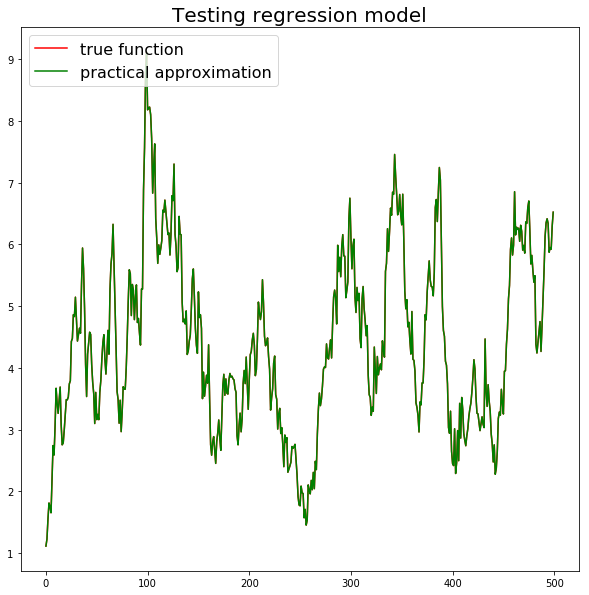

In [125]:
cur_lag = 0
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [126]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res = np.asarray(res)

M_n_2:  0.3110699868506939
M_n_2:  -20.60622880000229
M_n_1:  392.60015287813775
M_n_1:  -681.9267486249903
M_n_2:  -9.710846225578795
M_n_2:  13.087999004237266
M_n_1:  -126.89536503393434
M_n_1:  236.41646614895765
M_n_2:  15.58706765256111
M_n_1:  -62.865761967559855
M_n_2:  18.619628993503042
M_n_1:  -63.66635521482947
M_n_2:  -10.92345025957205
M_n_2:  -49.88626236979077
M_n_1:  354.0587675365737
M_n_1:  406.73193899474205
M_n_2:  -15.443236507561824
M_n_1:  1134.5414239126824
M_n_2:  41.181354670852464
M_n_1:  210.41947709142624
M_n_2:  -1.8602572489127314
M_n_1:  305.1922749053704
M_n_2:  20.642602845166778
M_n_1:  582.7797218974426
M_n_2:  -32.56234600108275
M_n_1:  -31.202597086472608
M_n_2:  15.400651850892753
M_n_1:  -293.57562195827984
M_n_2:  -2.7230185419520465
M_n_2:  18.260219435566437
M_n_1:  229.81836868574464
M_n_1:  387.2360856564897
M_n_2:  -11.121994580256736
M_n_2:  21.388124830629494
M_n_1:  -196.51737505788267
M_n_1:  252.5915562953353
M_n_2:  -11.0238341500159

In [127]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_1 = trav.starmap(test_traj, [(coefs_poly_1,2*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_1 = np.asarray(res_1)

M_n_2:  -0.5795562951468379
M_n_1:  343.7288639194688
M_n_2:  -21.36089510726086
M_n_2:  -8.957067507915415
M_n_1:  -501.5947538993263
M_n_1:  -96.29830208414378
M_n_2:  13.22396932229571
M_n_1:  166.02967340700192
M_n_2:  20.33092627725924
M_n_1:  -37.855740841488405
M_n_2:  -10.522281328828488
M_n_1:  254.88634243085622
M_n_2:  -52.295134365247826
M_n_1:  298.5896001275251
M_n_2:  16.548495120419876
M_n_1:  -35.86541731502293
M_n_2:  -15.960029977017648
M_n_1:  803.3349922747605
M_n_2:  -2.2660321287122356
M_n_1:  242.3143090221382
M_n_2:  21.490109527540568
M_n_2:  42.68131241877923
M_n_1:  150.78538106056584
M_n_1:  405.36643645422794
M_n_2:  17.216618179247867
M_n_1:  -220.2883657268275
M_n_2:  18.945377945866394
M_n_1:  261.2678006792142
M_n_2:  -33.47684547358057
M_n_2:  -3.2492286425921377
M_n_1:  151.2057559874237
M_n_1:  -10.097572031534142
M_n_2:  22.289097576545597
M_n_1:  168.88310500567962
M_n_2:  -11.76048924108923
M_n_1:  45.38212518563834
M_n_2:  0.882353003138274
M_n_

In [128]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_2 = trav.starmap(test_traj, [(coefs_poly_2,3*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_2 = np.asarray(res_2)

M_n_2:  -21.981247878611345
M_n_1:  -415.0460781960666
M_n_2:  -8.842261914203762
M_n_2:  13.878243825651264
M_n_1:  131.0495565460334
M_n_1:  -79.81015578331136
M_n_2:  -1.068399435884133
M_n_1:  305.67546506562866
M_n_2:  -10.221496902310236
M_n_2:  20.922762599575837
M_n_1:  219.80938970388726
M_n_1:  -27.418811659177837
M_n_2:  17.220919172848543
M_n_1:  -25.648010448859445
M_n_2:  -54.067494641246256
M_n_1:  249.9657570094385
M_n_2:  44.01490607581092
M_n_2:  -16.60582966977956
M_n_1:  131.77112584034884
M_n_1:  651.3938444070767
M_n_2:  22.319853560567246
M_n_1:  323.7655921264877
M_n_2:  -2.7941273832648488
M_n_1:  210.78431520535838
M_n_2:  18.54502841706182
M_n_2:  -3.647091230002402
M_n_1:  117.99460763166682
M_n_1:  -187.54325472488426
M_n_2:  19.427272443499195
M_n_1:  204.28874991014683
M_n_2:  -34.297199398062176
M_n_1:  -4.753517619398528
M_n_2:  0.18218512880207804
M_n_2:  -12.506233020436738
M_n_2:  23.039339015648032
M_n_2:  -11.022265801441245
M_n_1:  8.6578744767425

In [129]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_3 = trav.starmap(test_traj, [(coefs_poly_3,4*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_3 = np.asarray(res_3)

M_n_2:  -1.3705639743378206
M_n_1:  277.8221394029406
M_n_2:  14.630502180229968
M_n_2:  -8.916356694456876
M_n_2:  -22.677096550266576
M_n_1:  109.52560511923592
M_n_1:  -362.0771300349395
M_n_1:  -69.99733118191982
M_n_2:  -55.90797921819649
M_n_1:  220.01935515468867
M_n_2:  21.44441232304164
M_n_1:  -23.067748053805666
M_n_2:  17.837483018417956
M_n_1:  -21.401562140388528
M_n_2:  -10.026082880596192
M_n_1:  201.83818725817704
M_n_2:  45.48538895412819
M_n_1:  121.4755764307405
M_n_2:  -17.330421790013137
M_n_1:  559.7136020540447
M_n_2:  -3.2223320446141916
M_n_1:  189.6591066935918
M_n_2:  23.182729667243155
M_n_1:  276.7235050683172
M_n_2:  19.703229903547374
M_n_1:  -168.12447676127812
M_n_2:  -35.25585955187049
M_n_1:  -1.4376856331580237
M_n_2:  -3.928377420524438
M_n_2:  19.96309953354696
M_n_1:  99.8682297155677
M_n_1:  171.4401560594651
M_n_2:  23.7473950052153
M_n_1:  125.33367274536474
M_n_2:  -10.931943219677237
M_n_1:  -98.66083758395025
M_n_2:  -0.2865921343545241
M_n

In [130]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_4 = trav.starmap(test_traj, [(coefs_poly_4,5*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_4 = np.asarray(res_4)

M_n_2:  -23.484880764661455
M_n_1:  -325.3108097674335
M_n_2:  -1.5997954138012314
M_n_2:  15.409325229146418
M_n_2:  -9.072311510985292
M_n_1:  -64.03281948198928
M_n_1:  256.0793130220802
M_n_1:  95.24020660345417
M_n_2:  18.524451223024343
M_n_1:  -19.38002408122673
M_n_2:  -9.932197259506156
M_n_2:  -57.92733285193854
M_n_1:  190.37534217302255
M_n_1:  198.38433480351085
M_n_2:  22.0563040376468
M_n_1:  -21.259017104707507
M_n_2:  47.14082503768519
M_n_1:  114.22193412095847
M_n_2:  -3.5605873231256595
M_n_1:  173.54536429809997
M_n_2:  24.10101934616998
M_n_2:  -18.10606745357653
M_n_1:  246.0511844364442
M_n_1:  497.59839334088593
M_n_2:  20.58016582374153
M_n_1:  149.34429501204463
M_n_2:  -36.40146695244002
M_n_1:  1.9628283886959328
M_n_2:  -4.150518023480006
M_n_1:  88.76812860190054
M_n_2:  20.794572037524702
M_n_1:  -154.88410649905595
M_n_2:  -13.913617493009438
M_n_1:  16.200586059325527
M_n_2:  -10.948344524887892
M_n_1:  -92.8532861034724
M_n_2:  -0.6397588295660344
M_n

### Comparison plots

In [131]:
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[0:7])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    #ax.set_ylim(-0.12, 0.12)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)
    

def boxplot_ind(data, title, labels, path):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show() 

In [132]:
#data = [res_new[:,0],res_new[:,1],res_new[:,2]] 
#boxplot_ind(data, title, labels,path="./diffusion_quadratic_09_11.pdf")
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['MDCV-2, \n $\\gamma = 0.01$', 'MDCV-2, \n $\\gamma = 0.02$',\
          'MDCV-2, \n $\\gamma = 0.03$', 'MDCV-2, \n $\\gamma = 0.04$', 'MDCV-2, \n $\\gamma = 0.05$']#,\

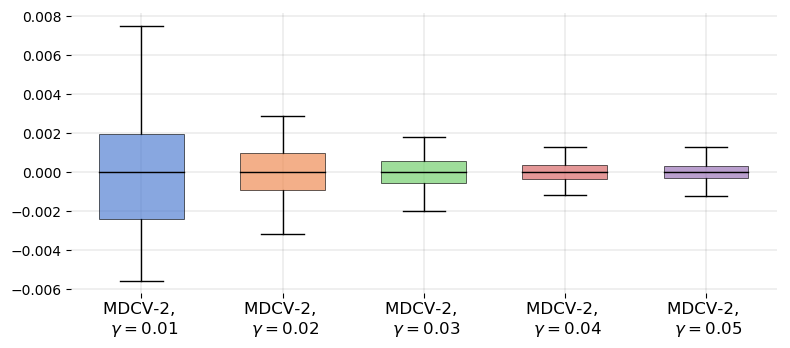

In [134]:
data = [res[:,2]-np.mean(res[:,2]),res_1[:,2]-np.mean(res_1[:,2]),res_2[:,2]-np.mean(res_2[:,2]),\
        res_3[:,2] - np.mean(res_3[:,2]),res_4[:,2] - np.mean(res_4[:,2])]#,res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./CIR_gamma_influence.pdf")